In this notebook, we will guide you through the step-by-step process to start training using eco4cast on your local machine. Follow along with the instructions to set up your environment and leverage the power of eco4cast. Let's get started!

You can find more info here:
https://github.com/AIRI-Institute/eco4cast/

# Usage example. Tutorial on training with MNIST <a name="3"></a>
## Prerequisites:
Before you begin, make sure you have the following:

- ElectricityMaps Account: Sign up for an ElectricityMaps account, as it will be used to monitor and manage the energy consumption and CO2 emissions of the VMs.
- Machine that is located in one of the supported zones.

## Currently supported zones list
- "BR-CS" (Central Brazil)
- "CA-ON" (Canada Ontario) 
- "CH" (Switzerland) 
- "DE" (Germany) 
- "PL" (Poland) 
- "BE" (Belgium) 
- "IT-NO" (North Italy) 
- "CA-QC" (Canada Quebec) 
- "ES" (Spain) 
- "GB" (Great Britain) 
- "FI" (Finland) 
- "FR" (France) 
- "NL" (Netherlands)

## Step 1. Setting up machine.


Create virtual environment (venv) on your machine and install necessary dependencies

In [ ]:
!pip install eco4cast
!pip install torchvision # Needed for MNIST dataset

## Step 2. Electricity Maps setup


Go to the [electricitymaps website](https://api-portal.electricitymaps.com/) and create an account. You may apply for free tier period (non-commercial use only) or subscribe to countries info.

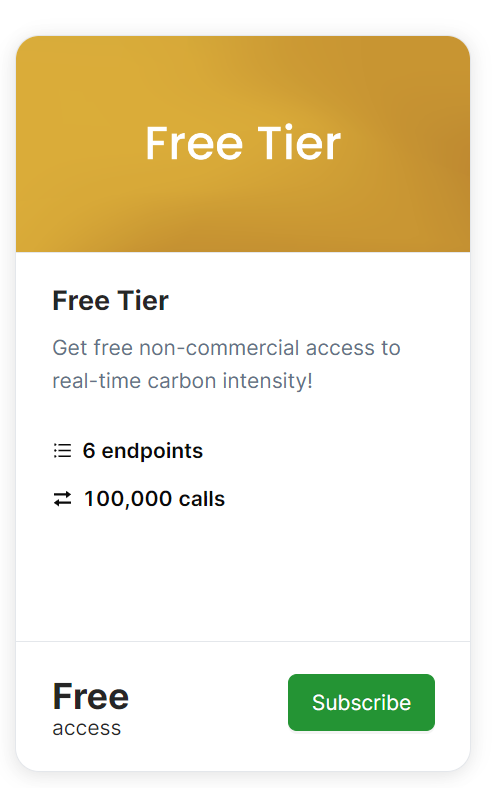


Then copy your primary API key. You will need it on Step 5.

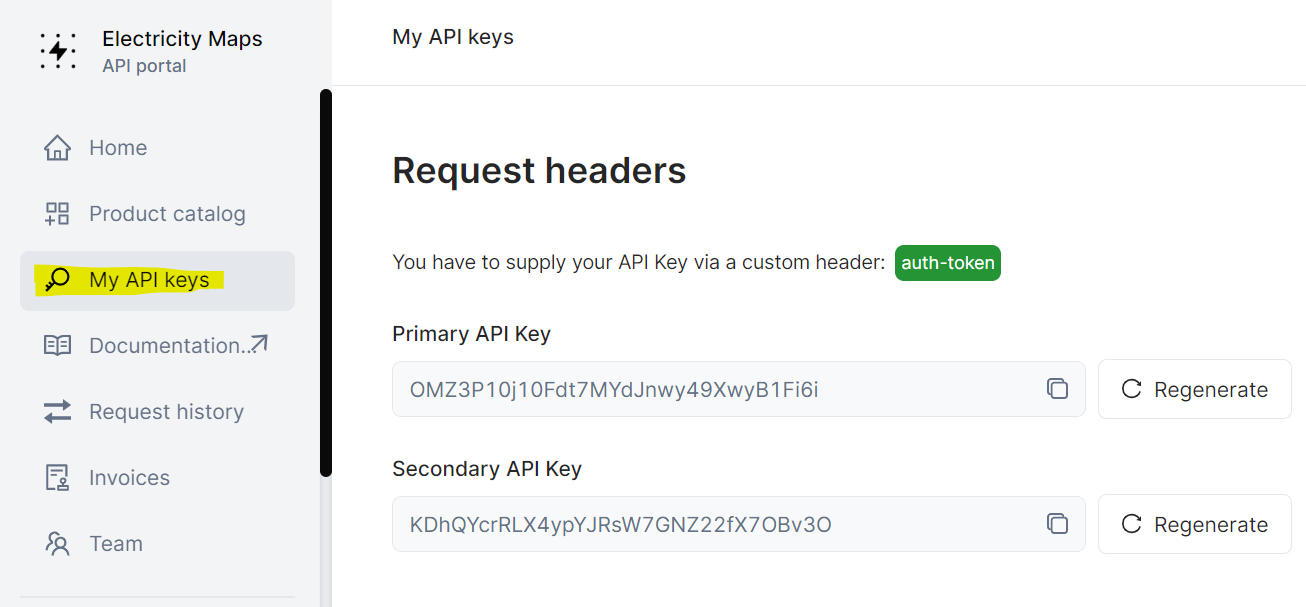


## Step 3. Initialize model and dataset


In this tutorial, we will be utilizing the MNIST dataset from the torchvision library and a basic convolutional model. However, you are free to choose any dataset and model that you prefer for your task.

In [1]:
from torch import nn
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output



transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = datasets.MNIST(
    "mnist_data", train=True, download=True, transform=transform
)
val_dataset = datasets.MNIST("mnist_data", train=False, transform=transform)


# Step 4. Setup necessary callbacks

eco4cast utilizes [Lighning Fabric](https://lightning.ai/docs/fabric/stable/) as a background framework, which allows the integration of callbacks in the training process. Here you can find two commonly used callbacks implemented by our team: EarlyStoppingCallback, BestModelSavingCallback

In [2]:
from eco4cast.master_machine.interval_predictor import CO2Predictor, IntervalGenerator
from eco4cast.virtual_machine.smart_scheduler_concept import IntervalTrainer

class EarlyStoppingCallback:
    def __init__(self, patience=5, mode="max") -> None:
        self.patience = patience
        self.metric_history = []
        assert mode in ["min", "max"]

        self.best_val_metric = 1e9 if mode == "min" else -1e9
        self.mode = mode

    def on_validation_epoch_end(
        self,
        trainer: IntervalTrainer,
        val_metric,
    ):
        val_metric = float(val_metric)
        self.metric_history.append(val_metric)
        if self.mode == "min":
            self.best_val_metric = min(self.best_val_metric, val_metric)
        else:
            self.best_val_metric = max(self.best_val_metric, val_metric)

        if self.best_val_metric not in self.metric_history[-self.patience - 1 :]:
            print("\n", "EarlyStopping")
            trainer.stop_training()


class BestModelSavingCallback:
    def __init__(self, mode="max") -> None:
        assert mode in ["min", "max"]
        self.best_val_metric = 1e9 if mode == "min" else -1e9
        self.mode = mode

    def on_validation_epoch_end(
        self,
        trainer: IntervalTrainer,
        val_metric,
    ):
        if (self.mode == "min" and val_metric < self.best_val_metric) or (
            self.mode == "max" and val_metric > self.best_val_metric
        ):
            self.best_val_metric = val_metric
            torch.save(trainer.model.state_dict(), "best_model.pth")
            print(
                "\n",
                f"Saving new best model with metric {self.best_val_metric}",
            )



# Step 5. Initialize training process

The IntervalTrainer class from the eco4cast package is a useful tool for training. It has a special feature that allows you to start and stop the training process without losing any important information. This class saves the current step information and applies it in the next interval, so the training process continues smoothly from where it left off in the previous batch, rather than starting from the beginning of the epoch.

Please specify your electricitymaps API key and zone on this step. 

Additionally, please note that when using the IntervalTrainer, you should pass torch Datasets as an argument, not Dataloaders. This is because the Dataloader is created within the trainer using a custom sampler.

In [5]:
electricity_maps_api_key = "gUZ7QzkmU91g50yliykpgOUdGQGUIDcD" # your API key here
your_zone = 'BE' # Choose zone from supported zones list


co2_predictor = CO2Predictor(electricity_maps_api_key, include_zones=[your_zone])
interval_generator=IntervalGenerator(include_zones=[your_zone], max_emission_value=115)


def accuracy(labels: torch.tensor, logits: torch.tensor):
    preds = logits.argmax(1)
    return (preds == labels).float().mean()

trainer = IntervalTrainer(
    model=Net(),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    loss_function=nn.CrossEntropyLoss(),
    metric_func=accuracy,
    val_step=None,
    show_progressbar=True,
    epochs=20,
    device="gpu",
    callbacks=[BestModelSavingCallback(), EarlyStoppingCallback(5)],
    project_name="MNIST_example",
)


trainer.train_using_predictor(co2_predictor, interval_generator)


100%|██████████| 13/13 [00:01<00:00,  8.17it/s]
/home/lazarev/disk/tiutiulnikov/SmartScheduler/venv/lib/python3.10/site-packages/eco2ai/emission_track.py:135: UserWarning: 
If you use a VPN, you may have problems with identifying your country by IP.
It is recommended to disable VPN or
manually install the ISO-Alpha-2 code of your country during initialization of the Tracker() class.
You can find the ISO-Alpha-2 code of your country here: https://www.iban.com/country-codes

  warnings.warn(


Predicted 1 interval(s)
Interval: 2023-08-15 16:00:00+00:00 - 2023-08-16 15:00:00+00:00 (UTC time)
Scheduling 2023-08-15 16:00:00+00:00 - 2023-08-16 15:00:00+00:00 job
Starting train from epoch 0, state: train,train_batch 0, val_batch 0


Train:  50%|████▉     | 3735/7500 [00:12<00:12, 294.75it/s]



 KeyboardInterrupt caught. Stopping scheduled jobs
+==================================================================================+
||                   Your total CO2 emissions are 0.018639 g.                     ||
||     0.000024 g were saved in comparison with average emission (0.018663 g)     ||
+==================================================================================+



 Shutting training till next interval


In the example, we were able to save approximately 0 grams of CO2 emissions during the training process. This means that the training process was as efficient as training without eco4cast.

However, if you were to use eco4cast for a long time in a region where CO2 levels are highly volatile, you would notice a significant difference in the results